Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [4]:
data = pd.read_excel("отзывы за лето.xls")
data.head(20)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
5,5,Всё удобно норм 👍👍👍,2017-08-14
6,5,Очень удобное приложение.,2017-08-14
7,5,Все устраивает,2017-08-14
8,5,У меня работает все четко. В отличии от банком...,2017-08-14
9,5,Очень все хорошо👍,2017-08-14


In [5]:
stop_words = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'\)+', ' веселый', txt)
    txt = re.sub(r'\(+', ' грустный', txt)
    txt = re.sub(r'[^\w\s]',' ', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop_words]
    txt = " ".join(txt)
    txt = re.sub("не\s", "не", txt)
    return txt

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3

In [6]:
data['target'] = data['target'].astype(int)
data.head()

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть большо...,1
2,5,Отлично все,2017-08-14,отлично,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,зависать работа антивирус ранее пользоваться н...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,удобно работать быстро,1


### Учим conv сеть для классификации

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [8]:
X_train.shape, X_val.shape

((15798,), (3950,))

In [9]:
y_train.shape, y_val.shape

((15798,), (3950,))

In [10]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index
print(len(word_index))

7077


In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)
print(X_train[0])
print(X_train.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3155  261]
(15798, 112)


In [12]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val)

In [13]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

In [15]:
VOCAB_SIZE = len(word_index)+1
EMBEDDING_DIM = 128
WEIGHT_DECAY = 0.005
wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 1, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 4, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
#     tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         905984    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         16512     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         32896     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         6

In [16]:
%%time
num_epochs = 5
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/5
124/124 [==============================] - 6s 49ms/step - loss: 1.7362 - auc: 0.8292 - val_loss: 0.8271 - val_auc: 0.8732
Epoch 2/5
124/124 [==============================] - 4s 32ms/step - loss: 0.4216 - auc: 0.9551 - val_loss: 0.4963 - val_auc: 0.9463
Epoch 3/5
124/124 [==============================] - 4s 32ms/step - loss: 0.2540 - auc: 0.9693 - val_loss: 0.3709 - val_auc: 0.9483
Epoch 4/5
124/124 [==============================] - 4s 32ms/step - loss: 0.2040 - auc: 0.9746 - val_loss: 0.2862 - val_auc: 0.9480
Epoch 5/5
124/124 [==============================] - 4s 32ms/step - loss: 0.1745 - auc: 0.9801 - val_loss: 0.2389 - val_auc: 0.9521
Wall time: 24.6 s


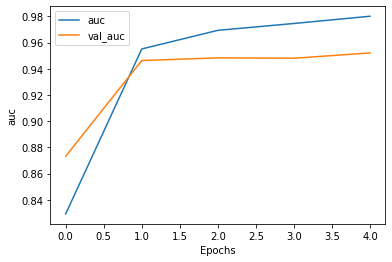

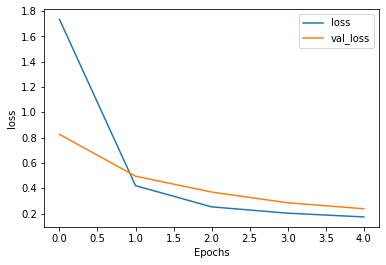

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc")  
plot_graphs(history, "loss")

### Предобучаем word2vec

In [18]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
import gensim.downloader as api
from gensim.corpora import Dictionary

In [19]:
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [20]:
docs = X_train.tolist()
text_corpus = [[word for word in document.split()] for document in docs]
text_corpus[:5]

[['еакий', 'очередь'],
 ['приятный', 'приложение', 'понятно'],
 ['удобно'],
 ['отличный', 'приложение'],
 ['хороший', 'программа', 'удобный', 'довольный']]

In [21]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_corpus)
print(dictionary)

Dictionary(7078 unique tokens: ['еакий', 'очередь', 'понятно', 'приложение', 'приятный']...)


In [22]:
model = Word2Vec(text_corpus, size=EMBEDDING_DIM, window=5, workers=cpu_count())

In [23]:
model.wv['очередь']

array([ 0.20860627,  0.10702743,  0.11708379, -0.13609871,  0.1958432 ,
       -0.02471638,  0.20257597, -0.26995918, -0.18981951, -0.01991258,
       -0.00875107,  0.26073638,  0.2681802 , -0.00146808,  0.01520786,
        0.01939542, -0.2453978 ,  0.2859269 , -0.05985853,  0.31848663,
        0.4939633 ,  0.00679542,  0.06554444,  0.0778994 ,  0.17192161,
        0.01561149, -0.05586119, -0.00491568, -0.1422226 , -0.22148685,
        0.17382756,  0.18218729, -0.04301676, -0.0325054 ,  0.16911726,
        0.21618156,  0.03112095, -0.03181714,  0.0524686 ,  0.14389023,
        0.13222311, -0.00751175,  0.00224228,  0.48967317, -0.16399223,
        0.29786897, -0.12723608,  0.05988308,  0.08611988,  0.32930052,
       -0.17971635,  0.21675986, -0.11561282, -0.07421737, -0.08645628,
       -0.09269209, -0.19608371,  0.2756789 , -0.1131015 ,  0.02334909,
       -0.07863683,  0.04195431,  0.37278324,  0.24138927, -0.12322825,
       -0.0530115 ,  0.34798133,  0.22098751,  0.00937551,  0.15

In [24]:
WEIGHTS = np.zeros((len(dictionary), EMBEDDING_DIM))
WEIGHTS.shape

(7078, 128)

In [25]:
for token in dictionary:
    if dictionary[token] in model.wv:
        WEIGHTS[token] = model.wv[dictionary[token]]

In [29]:
VOCAB_SIZE = len(word_index)+1
EMBEDDING_DIM = 128
WEIGHT_DECAY = 0.005
wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[WEIGHTS]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 1, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 4, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=wd),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
#     tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         16512     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 128)         32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 128)        

In [30]:
%%time
num_epochs = 5
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/5
124/124 [==============================] - 4s 34ms/step - loss: 2.3195 - auc_2: 0.7974 - val_loss: 1.3517 - val_auc_2: 0.9000
Epoch 2/5
124/124 [==============================] - 4s 32ms/step - loss: 0.7964 - auc_2: 0.9317 - val_loss: 0.6258 - val_auc_2: 0.9536
Epoch 3/5
124/124 [==============================] - 4s 32ms/step - loss: 0.4258 - auc_2: 0.9562 - val_loss: 0.4430 - val_auc_2: 0.9527
Epoch 4/5
124/124 [==============================] - 4s 32ms/step - loss: 0.2888 - auc_2: 0.9686 - val_loss: 0.3106 - val_auc_2: 0.9568
Epoch 5/5
124/124 [==============================] - 4s 32ms/step - loss: 0.2406 - auc_2: 0.9716 - val_loss: 0.3145 - val_auc_2: 0.9440
Wall time: 21.3 s


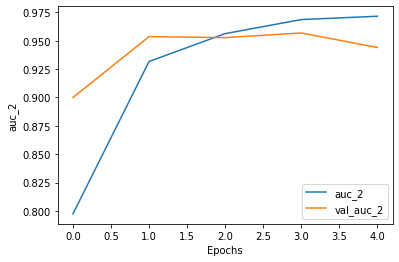

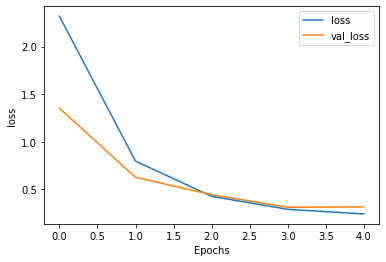

In [31]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_2")  
plot_graphs(history, "loss")

Существенно улучшить модель не удалось, но, если поработать над регуляризацией, возможно, вторая модель заработает лучше.